# 信用卡詐欺偵測

此資料集包含歐洲持卡人在 2013 年 9 月使用信用卡進行的交易。
該資料集呈現了兩天內發生的交易，在 284,807 筆交易中，我們發現了 492 筆詐欺交易。此資料集高度不平衡，正類（詐欺）交易占所有交易的 0.172%。

特徵 V1、V2、…V28 是透過 PCA 獲得的主成分，唯一未經過 PCA 轉換的特徵是「時間」和「金額」。特徵「時間」包含資料集中每筆交易與第一筆交易之間相隔的秒數。特徵「金額」是交易金額，此特徵可用於依賴範例的成本敏感學習。特徵「類別」是回應變量，在有詐欺的情況下取值為 1，否則取值為 0。

考慮到類別不平衡率，建議使用精確度-召回率曲線下面積 (AUPRC) 來衡量準確率。對於不平衡的分類，混淆矩陣準確率意義不大。

In [ ]:
! pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,learning_curve
import xgboost as xgb
import shap
# print the JS visualization code to the notebook
shap.plots.initjs()
from sklearn import metrics
from sklearn.metrics import roc_auc_score ,roc_curve ,classification_report ,confusion_matrix ,accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
# plt.rc('font', family='Microsoft JhengHei') # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# 讀取與確認資料

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
X = df.drop(columns =['Class'])
y = df['Class']

print('X:', X.shape) # (284807, 30)
print('Y:', y.shape) # (284807,)

X: (284807, 30)
Y: (284807,)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,284807.00,2.85e+05
mean,94813.86,1.17e-15,3.42e-16,-1.38e-15,2.07e-15,9.60e-16,1.49e-15,-5.56e-16,1.21e-16,-2.41e-15,2.24e-15,1.67e-15,-1.25e-15,8.19e-16,1.21e-15,4.89e-15,1.44e-15,-3.77e-16,9.56e-16,1.04e-15,6.41e-16,1.65e-16,-3.57e-16,2.58e-16,4.47e-15,5.34e-16,1.68e-15,-3.66e-16,-1.23e-16,88.35,1.73e-03
std,47488.15,1.96e+00,1.65e+00,1.52e+00,1.42e+00,1.38e+00,1.33e+00,1.24e+00,1.19e+00,1.10e+00,1.09e+00,1.02e+00,9.99e-01,9.95e-01,9.59e-01,9.15e-01,8.76e-01,8.49e-01,8.38e-01,8.14e-01,7.71e-01,7.35e-01,7.26e-01,6.24e-01,6.06e-01,5.21e-01,4.82e-01,4.04e-01,3.30e-01,250.12,4.15e-02
min,0.00,-5.64e+01,-7.27e+01,-4.83e+01,-5.68e+00,-1.14e+02,-2.62e+01,-4.36e+01,-7.32e+01,-1.34e+01,-2.46e+01,-4.80e+00,-1.87e+01,-5.79e+00,-1.92e+01,-4.50e+00,-1.41e+01,-2.52e+01,-9.50e+00,-7.21e+00,-5.45e+01,-3.48e+01,-1.09e+01,-4.48e+01,-2.84e+00,-1.03e+01,-2.60e+00,-2.26e+01,-1.54e+01,0.00,0.00e+00
25%,54201.50,-9.20e-01,-5.99e-01,-8.90e-01,-8.49e-01,-6.92e-01,-7.68e-01,-5.54e-01,-2.09e-01,-6.43e-01,-5.35e-01,-7.62e-01,-4.06e-01,-6.49e-01,-4.26e-01,-5.83e-01,-4.68e-01,-4.84e-01,-4.99e-01,-4.56e-01,-2.12e-01,-2.28e-01,-5.42e-01,-1.62e-01,-3.55e-01,-3.17e-01,-3.27e-01,-7.08e-02,-5.30e-02,5.60,0.00e+00
50%,84692.00,1.81e-02,6.55e-02,1.80e-01,-1.98e-02,-5.43e-02,-2.74e-01,4.01e-02,2.24e-02,-5.14e-02,-9.29e-02,-3.28e-02,1.40e-01,-1.36e-02,5.06e-02,4.81e-02,6.64e-02,-6.57e-02,-3.64e-03,3.73e-03,-6.25e-02,-2.95e-02,6.78e-03,-1.12e-02,4.10e-02,1.66e-02,-5.21e-02,1.34e-03,1.12e-02,22.00,0.00e+00
75%,139320.50,1.32e+00,8.04e-01,1.03e+00,7.43e-01,6.12e-01,3.99e-01,5.70e-01,3.27e-01,5.97e-01,4.54e-01,7.40e-01,6.18e-01,6.63e-01,4.93e-01,6.49e-01,5.23e-01,4.00e-01,5.01e-01,4.59e-01,1.33e-01,1.86e-01,5.29e-01,1.48e-01,4.40e-01,3.51e-01,2.41e-01,9.10e-02,7.83e-02,77.16,0.00e+00
max,172792.00,2.45e+00,2.21e+01,9.38e+00,1.69e+01,3.48e+01,7.33e+01,1.21e+02,2.00e+01,1.56e+01,2.37e+01,1.20e+01,7.85e+00,7.13e+00,1.05e+01,8.88e+00,1.73e+01,9.25e+00,5.04e+00,5.59e+00,3.94e+01,2.72e+01,1.05e+01,2.25e+01,4.58e+00,7.52e+00,3.52e+00,3.16e+01,3.38e+01,25691.16,1.00e+00


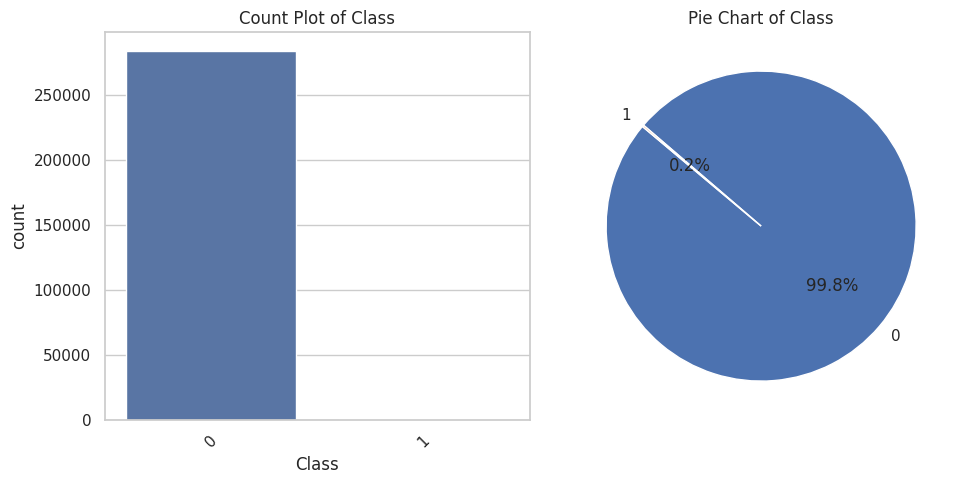

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# counts = np.bincount(y)
# for i, count in enumerate(counts):
#     print(f"Class {i}: {count} instances")
use_columns = ['Class']
for col in use_columns:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    profile_counts = df[col].value_counts()
    plt.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart of {col}')
    plt.tight_layout()
    plt.show()
    print(df[col].value_counts())

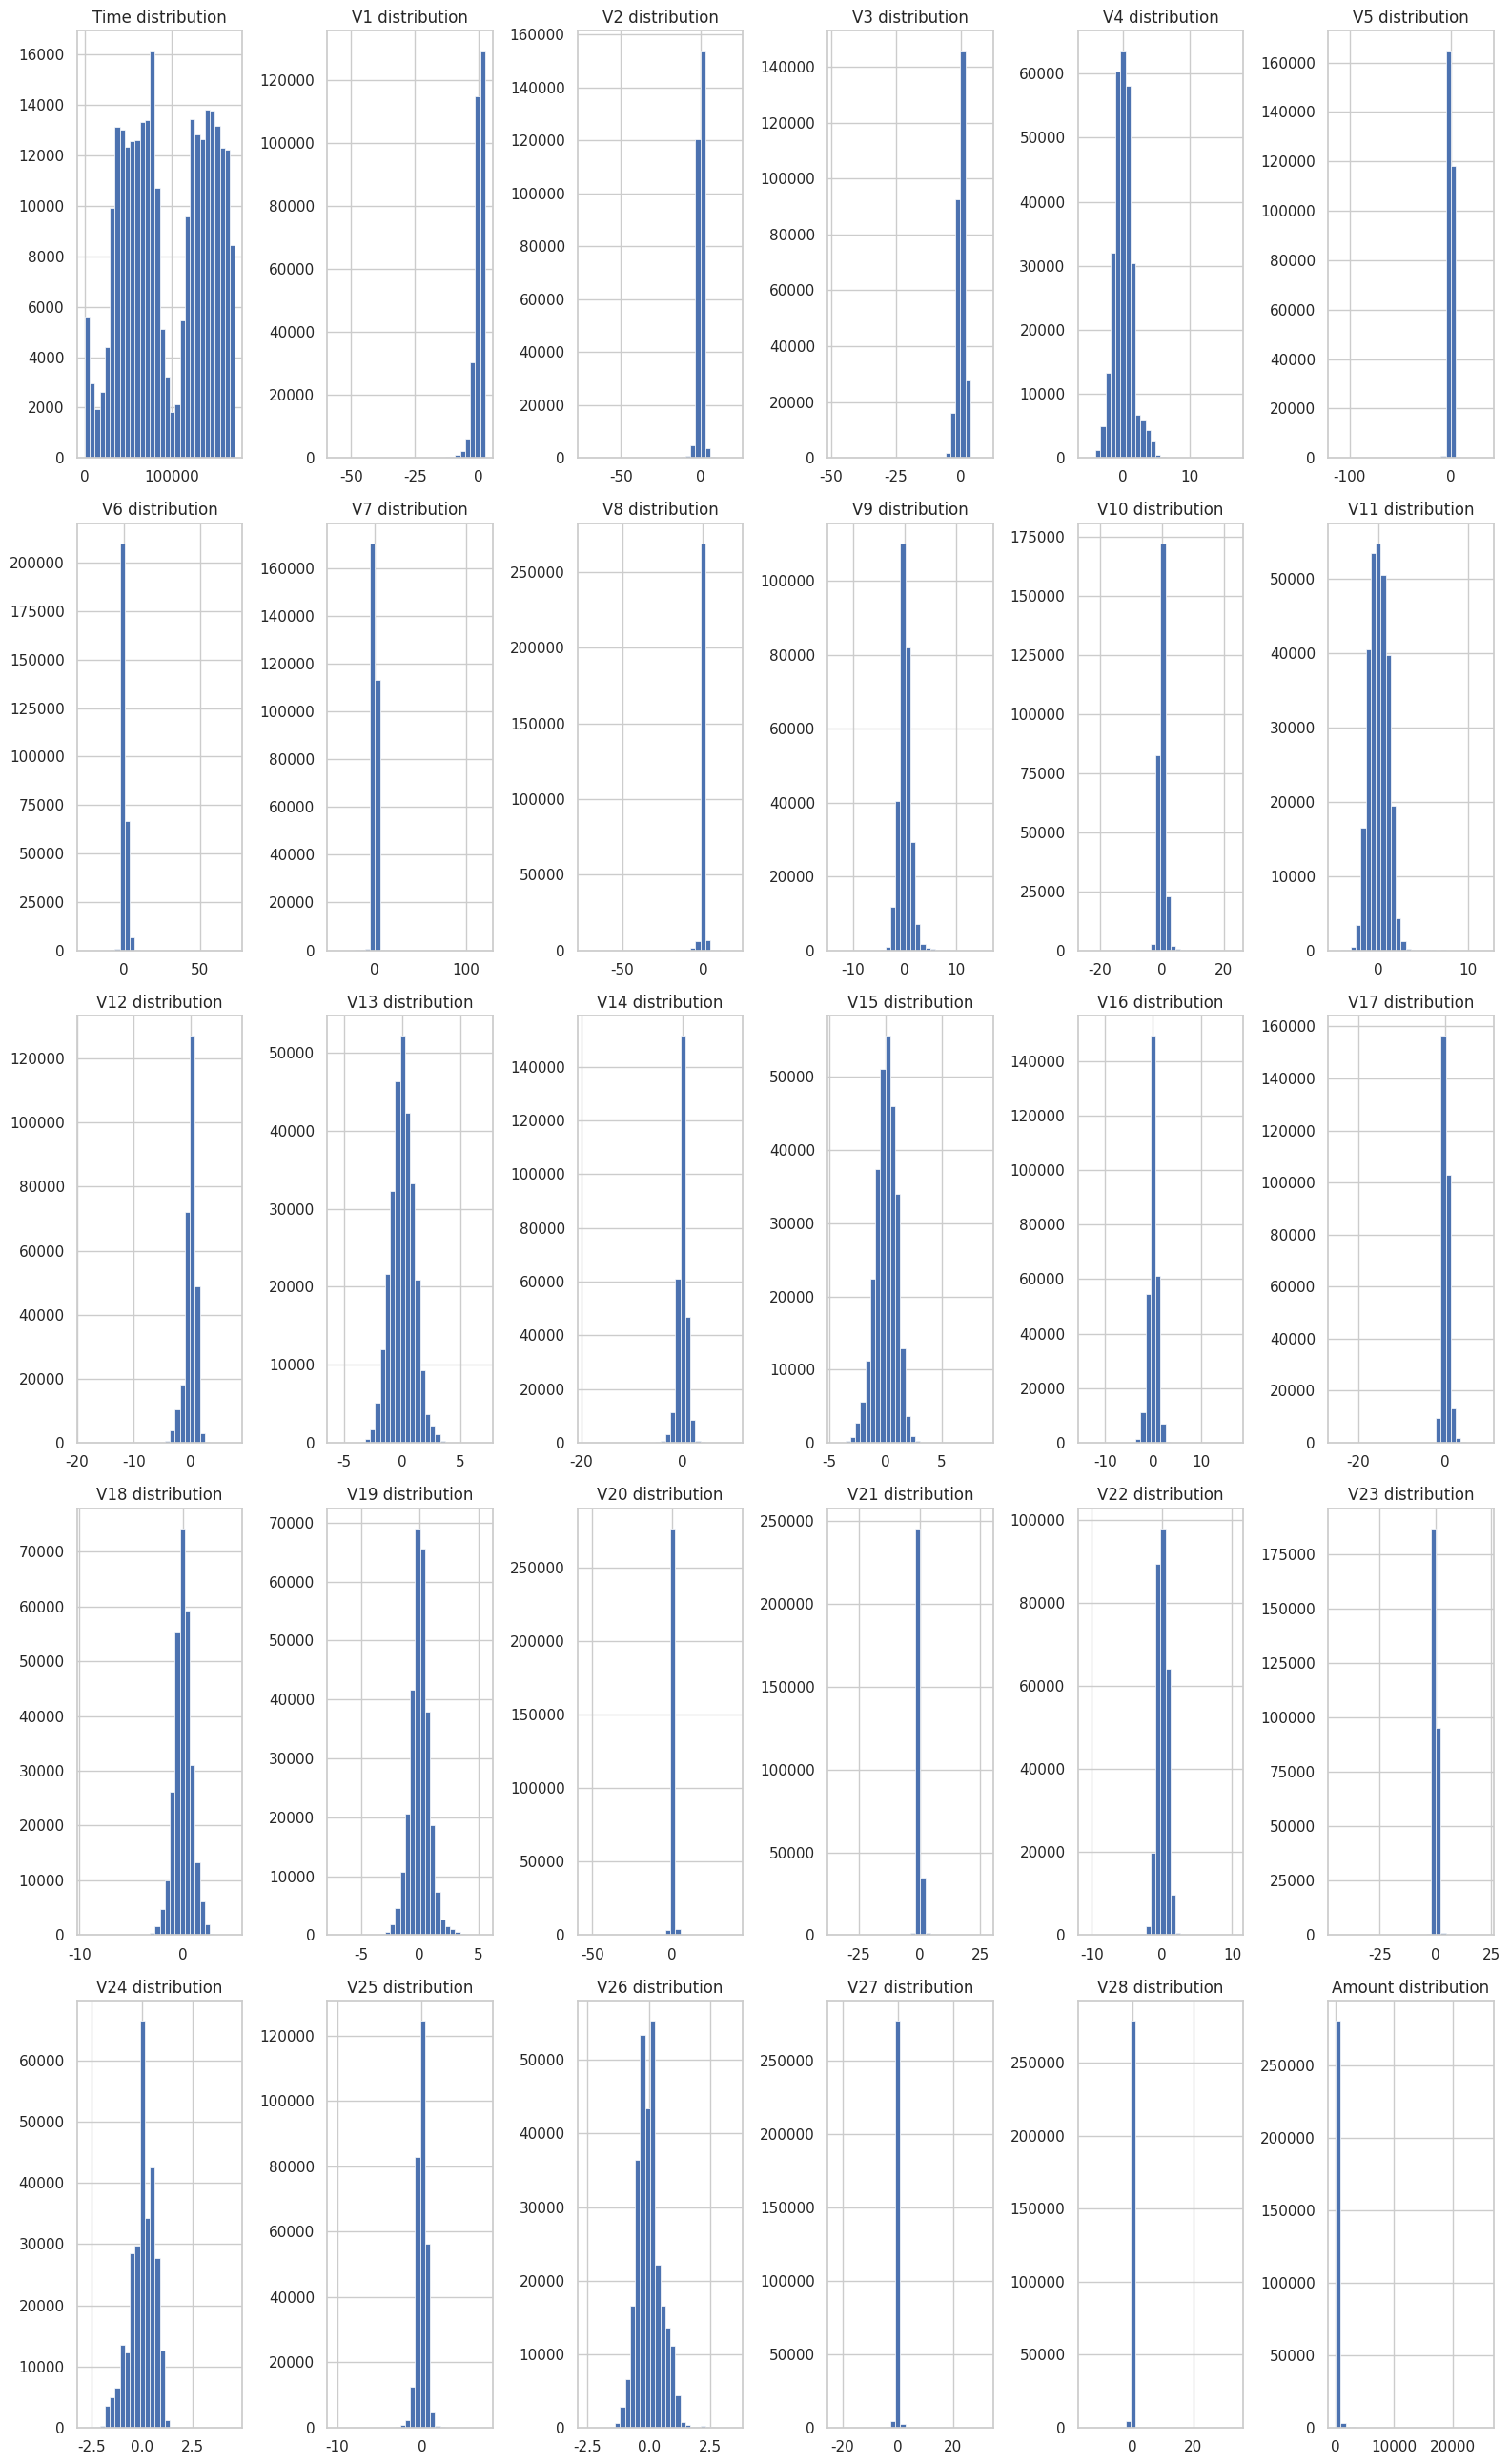

In [ ]:
# 繪製直方圖
fig, axes = plt.subplots(nrows=5, ncols=6,figsize=(16,26))
feature_list = df.columns.to_list()

bins_value = 30
linewidth_value = 0.5
list_count = 0

for i in range(0, 5):
    for j in [0, 1, 2, 3, 4, 5]:
        feature_name = feature_list[list_count]
        axes[i,j].hist(df[feature_name], bins=bins_value, linewidth=linewidth_value, edgecolor="white")
        axes[i,j].set_title("{} distribution".format(feature_name))
        list_count += 1
plt.tight_layout()

# 資料切割

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ,stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))
print('='*40)
print(pd.Series(y_test).value_counts())
print(pd.Series(y_test).value_counts(normalize=True))

(227845, 30) (56962, 30) (227845,) (56962,)
Class
0    227451
1       394
Name: count, dtype: int64
Class
0    9.98e-01
1    1.73e-03
Name: proportion, dtype: float64
Class
0    56864
1       98
Name: count, dtype: int64
Class
0    9.98e-01
1    1.72e-03
Name: proportion, dtype: float64


In [ ]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
265518,161919.0,1.95,-0.75,-1.36,-0.66,1.50,4.02,-1.48e+00,1.14,1.41e+00,-0.16,-0.11,0.51,0.06,-0.07,1.33,0.35,-0.77,0.14,-4.51e-01,-0.13,0.08,0.30,3.08e-01,0.69,-0.35,-0.39,7.76e-02,-3.22e-02,7.32
180305,124477.0,2.04,-0.05,-3.06,0.25,2.94,3.30,-2.19e-03,0.67,4.58e-02,0.28,-0.25,0.33,-0.41,0.72,-0.15,-0.75,-0.27,-0.70,-2.74e-01,-0.23,0.04,0.23,3.55e-02,0.71,0.51,-0.47,2.52e-03,-6.90e-02,2.99
42664,41191.0,-0.99,0.60,0.71,-0.99,-0.83,1.96,-2.21e+00,-5.04,7.72e-04,-2.01,-0.39,1.82,0.75,0.12,-1.72,1.12,-0.72,0.15,4.63e-03,1.28,-2.80,0.11,-4.37e-01,-0.93,0.83,0.91,3.80e-02,1.85e-01,175.10
198723,132624.0,2.29,-1.50,-0.75,-1.67,-1.39,-0.35,-1.43e+00,0.01,-1.12e+00,1.76,0.09,-0.72,-0.47,-0.20,-0.64,-0.07,0.07,0.77,2.57e-01,-0.49,-0.14,0.08,2.08e-01,-0.54,-0.28,-0.16,1.80e-02,-6.30e-02,6.10
82325,59359.0,-0.45,-1.01,0.12,-3.45,0.72,-0.15,5.04e-01,-0.11,-4.48e-02,-0.56,-0.25,-0.05,-0.78,0.13,-0.48,-2.10,-0.40,1.60,-8.27e-02,-0.28,-0.24,-0.17,-6.69e-03,-1.36,-0.29,-0.14,-3.26e-02,-6.42e-02,86.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,147710.0,1.99,-0.52,-0.62,0.13,-0.29,0.40,-8.22e-01,0.23,9.96e-01,0.21,0.32,0.58,-0.25,0.06,0.01,0.68,-0.91,0.74,4.39e-02,-0.17,0.26,0.88,9.91e-02,0.28,-0.20,0.62,-3.25e-02,-5.86e-02,5.99
85418,60764.0,-1.50,0.66,1.58,-0.02,0.58,1.30,6.09e-01,0.14,4.53e-01,0.11,0.52,0.37,-0.53,-0.40,0.77,-1.88,1.24,-2.62,-1.24e+00,-0.23,-0.07,0.30,1.10e-01,-0.62,-0.43,0.26,-4.48e-01,4.52e-02,36.99
29062,35301.0,1.07,0.07,0.50,1.51,-0.38,-0.37,1.01e-01,-0.03,3.20e-01,-0.13,-0.31,0.45,-0.55,0.17,-0.07,-0.80,0.40,-1.03,-5.00e-01,-0.15,-0.06,-0.04,-5.05e-02,0.40,0.59,-0.34,3.10e-02,2.49e-02,45.42
13766,24413.0,1.28,0.30,0.33,0.51,0.07,-0.15,-1.46e-01,-0.09,1.11e+00,-0.27,1.71,-1.67,2.12,1.80,-0.36,0.71,-0.25,0.48,2.79e-01,-0.09,-0.41,-0.96,3.32e-02,-0.56,0.28,0.09,-5.98e-02,-5.89e-03,0.89


# 初始模型建立

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# 設計評估指標def() 函式

Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.98      0.96      0.97       394

    accuracy                           1.00    227845
   macro avg       0.99      0.98      0.99    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.96      0.97        98

    accuracy                           1.00     56962
   macro avg       0.99      0.98      0.99     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 0.995030
Test AUC: 0.995877


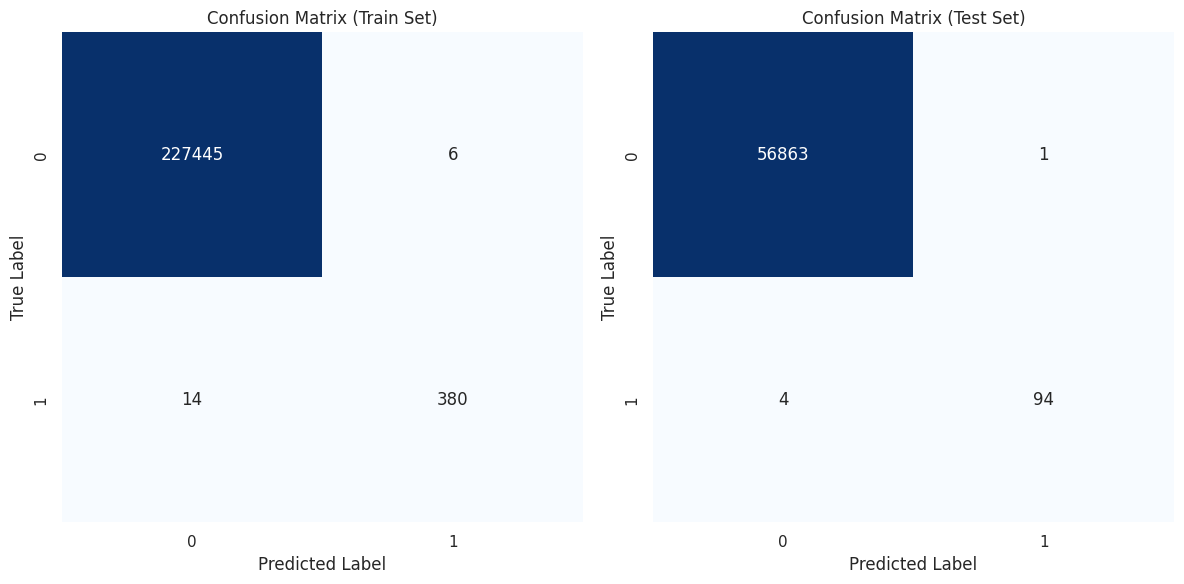

In [ ]:
# 分類報告和混淆矩陣
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("Train Set:")
    print(classification_report(y_train, y_train_pred))
    print("Test Set:")
    print(classification_report(y_test, y_test_pred))

    # 計算 AUC（適用於多分類）
    # train_auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    # test_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    # 計算 AUC（二元分類）
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Train AUC: {train_auc:.6f}")
    print(f"Test AUC: {test_auc:.6f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Train Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

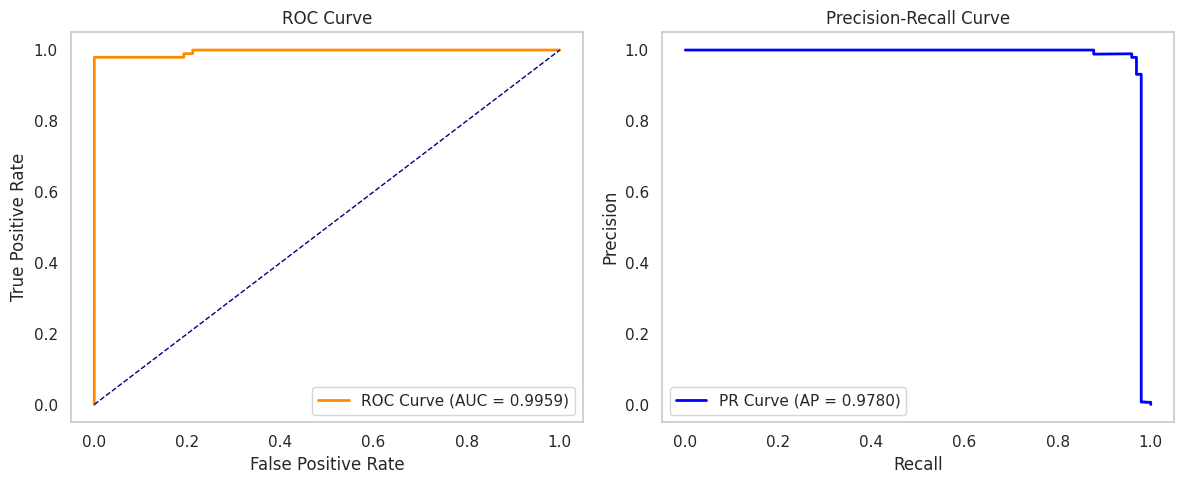

In [ ]:
# ROC 曲線 和 PR 曲線
def plot_roc_pr_curves(model, X_test, y_test):
    # 預測機率值
    y_score = model.predict_proba(X_test)[:, 1]

    # === ROC 曲線 ===
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # === PR 曲線 ===
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)

    # === 畫圖 ===
    plt.figure(figsize=(12, 5))

    # ROC 曲線
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()

    # PR 曲線
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()
plot_roc_pr_curves(xgb_model, X_test, y_test)

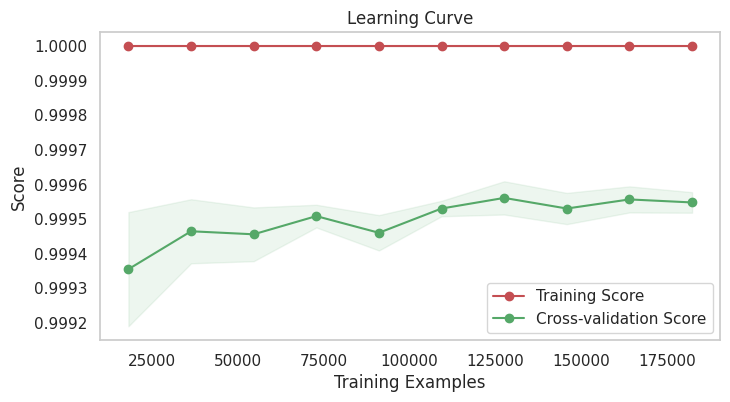

Train Sizes: [ 18227  36455  54682  72910  91138 109365 127593 145820 164048 182276]
Train Scores Mean: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores Mean: [0.99935482 0.99946455 0.99945577 0.99950844 0.99946016 0.99953038
 0.99956111 0.99953038 0.99955672 0.99954794]


In [ ]:
# 學習曲線
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 4))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()

    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_model, X_train, y_train)

In [ ]:
# 各 模型的 ROC 曲線 和 PR 曲線
def plot_combined_roc_pr_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 5))

    # ===== ROC 曲線 =====
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (All Models)')
    plt.legend(loc='lower right')
    plt.grid()

    # ===== PR 曲線 =====
    plt.subplot(1, 2, 2)
    for name, model in models.items():
        y_score = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        avg_precision = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (All Models)')
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()


===== 訓練 RandomForest 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.963027


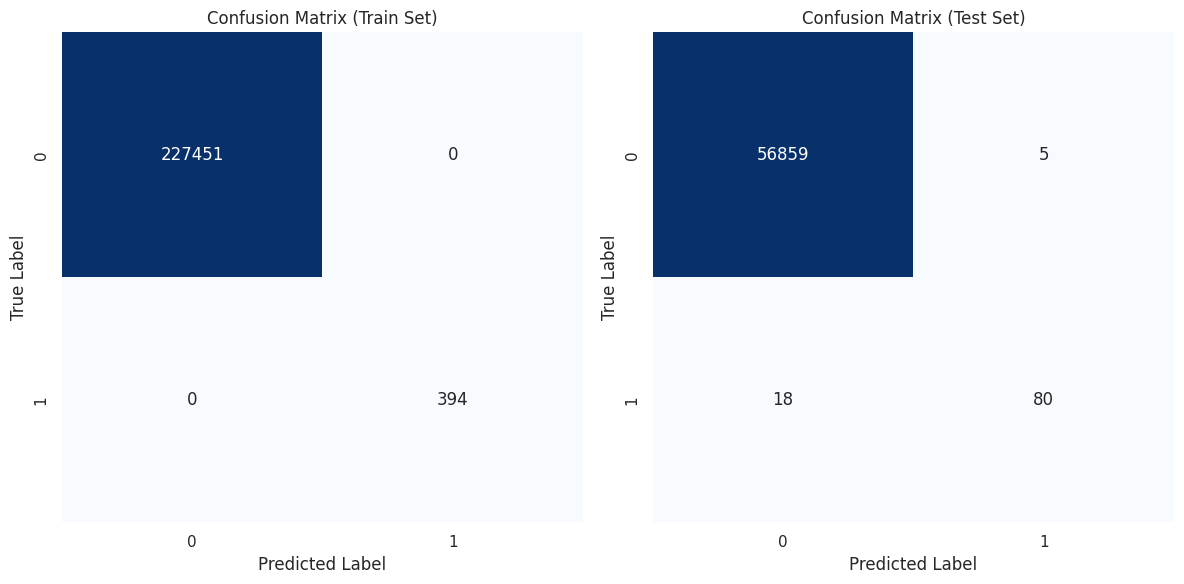


===== 訓練 LightGBM 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.64      0.66      0.65       394

    accuracy                           1.00    227845
   macro avg       0.82      0.83      0.83    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.62      0.55        98

    accuracy                           1.00     56962
   macro avg       0.75      0.81      0.78     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 0.832138
Test AUC: 0.820311


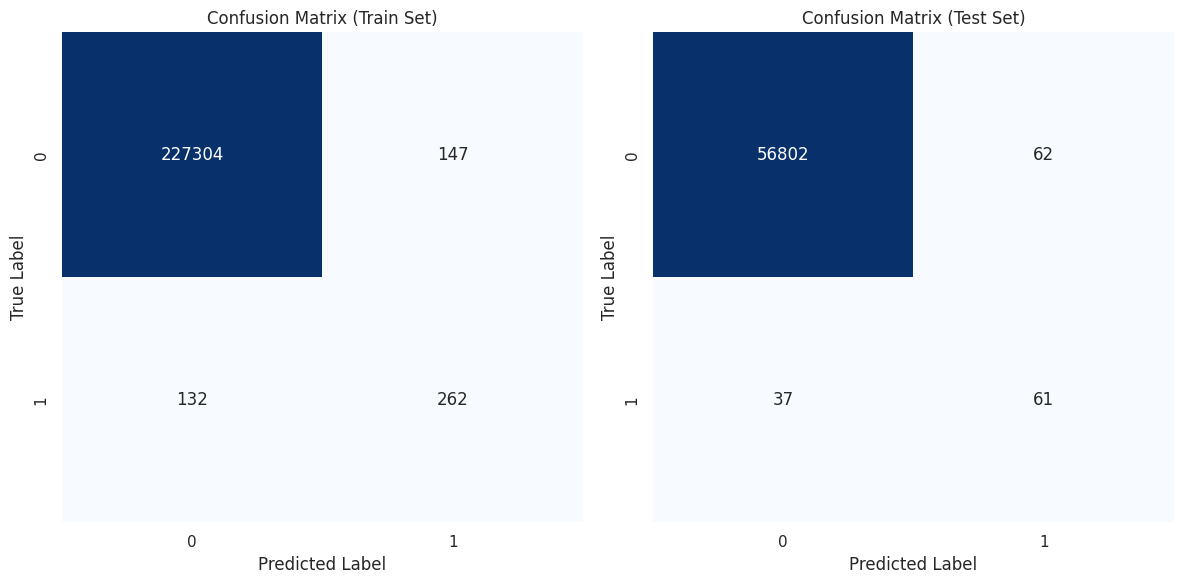


===== 訓練 XGBoost 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.974323


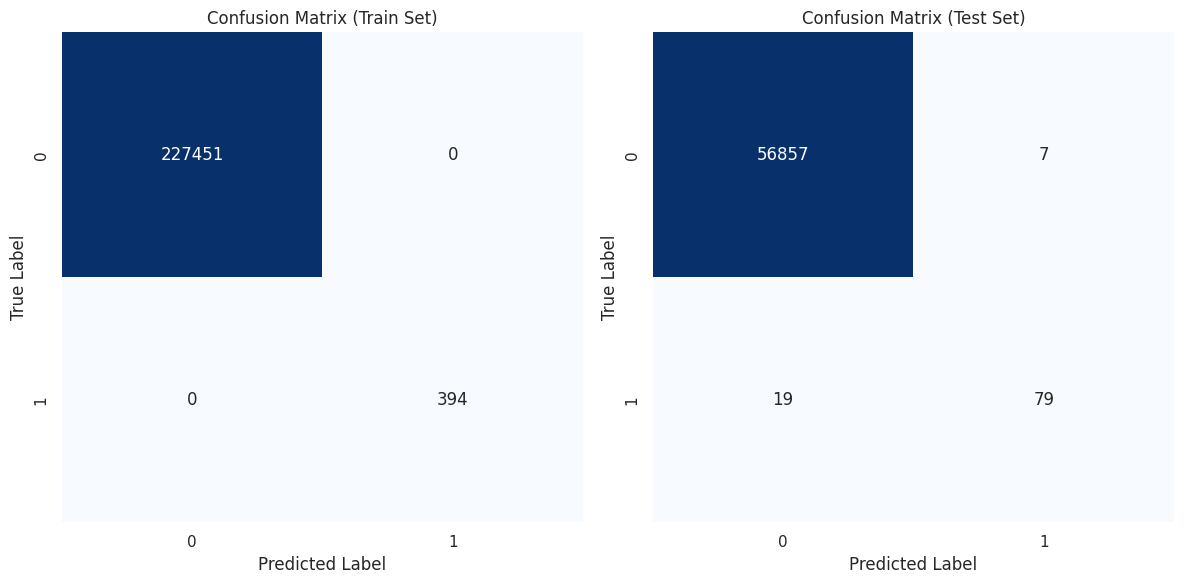


===== 訓練 LogisticRegression 模型 =====


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.69      0.69      0.69       394

    accuracy                           1.00    227845
   macro avg       0.84      0.84      0.84    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.73      0.71        98

    accuracy                           1.00     56962
   macro avg       0.85      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 0.900219
Test AUC: 0.935672


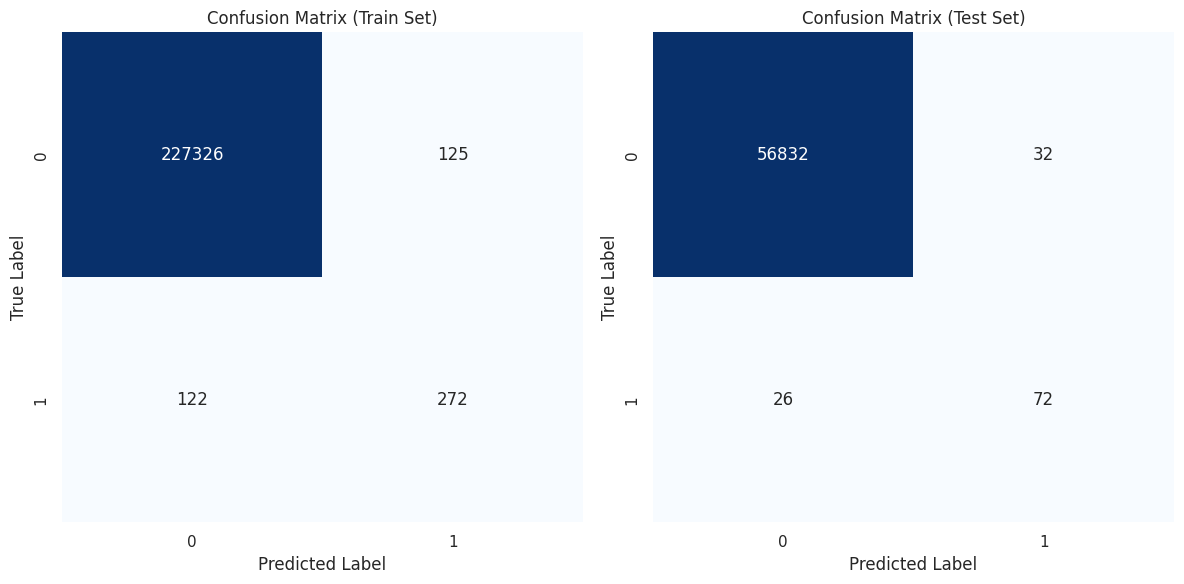


===== 訓練 DecisionTree 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.74      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.872238


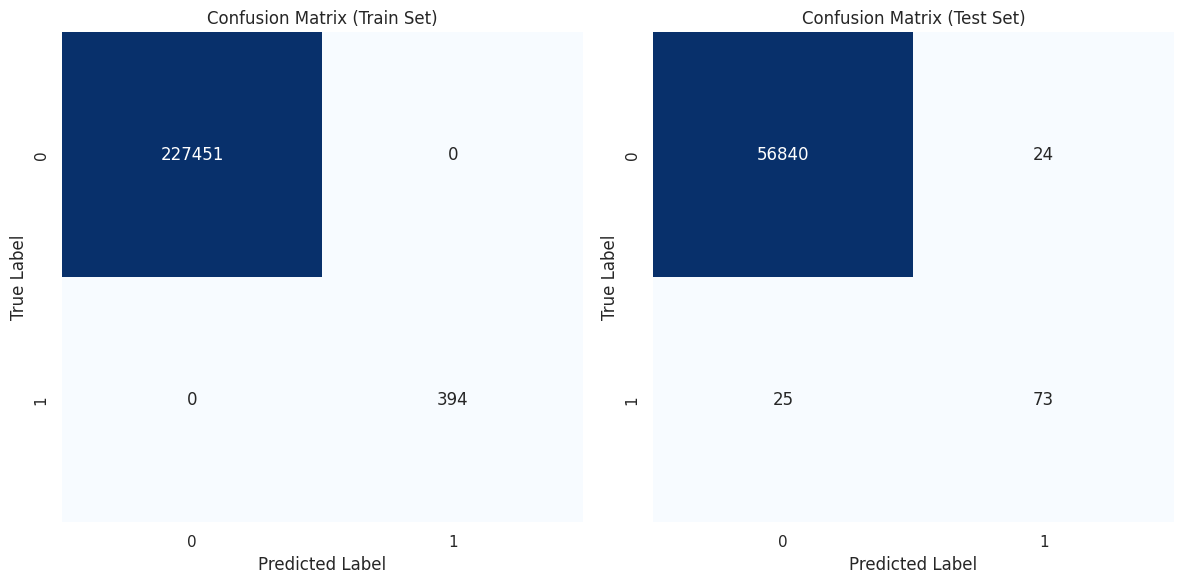

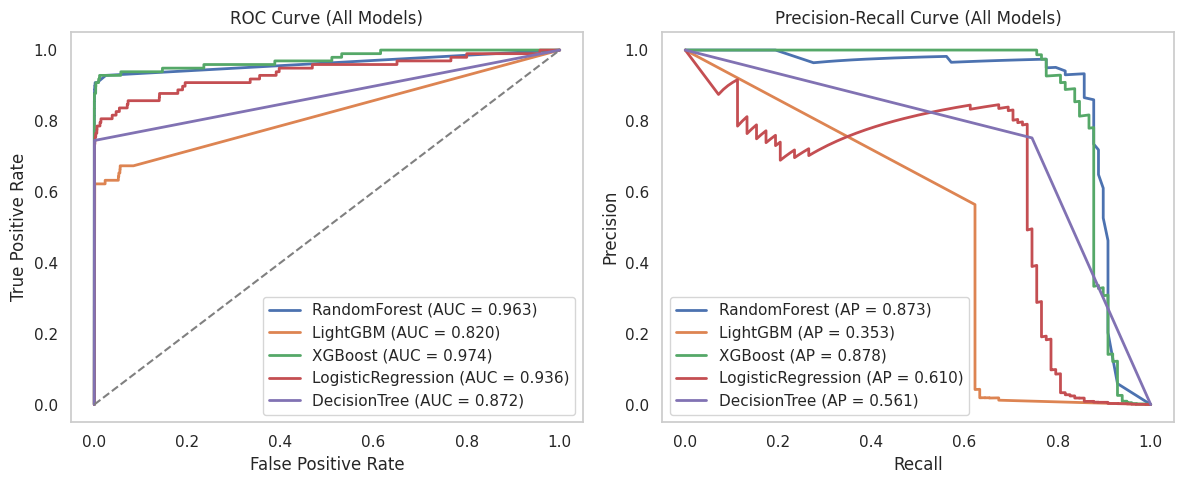

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

for name, model in models.items():
    print(f"\n===== 訓練 {name} 模型 =====")
    model.fit(X_train, y_train)
    evaluate_model(model, X_train, y_train, X_test, y_test)
print('='*50)
plot_combined_roc_pr_curves(models, X_test, y_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 設定 KFold 的參數
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 儲存每次交叉驗證的結果
fold_accuracies = []
fold_aucs = []
fold_reports = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # 建立 XGBoost 模型
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train_fold, y_train_fold)

    # 預測與評估
    y_val_pred = xgb_model.predict(X_val_fold)
    y_val_pred_proba = xgb_model.predict_proba(X_val_fold)

    acc = accuracy_score(y_val_fold, y_val_pred)

    # 二分類 AUC 計算
    if len(np.unique(y_val_fold)) == 2:
        auc = roc_auc_score(y_val_fold, y_val_pred_proba[:, 1])
    else:
        auc = np.nan

    report = classification_report(y_val_fold, y_val_pred, output_dict=True)

    fold_accuracies.append(acc)
    fold_aucs.append(auc)
    fold_reports.append(report)

    print(classification_report(y_val_fold, y_val_pred))
    print(f"AUC: {auc:.4f}")
    print("=" * 50)

# 顯示整體結果
print(f"\n平均準確率 (Accuracy): {np.mean(fold_accuracies):.4f}")
print(f"平均 AUC: {np.nanmean(fold_aucs):.4f}")

Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.76      0.84        99

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9798
Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      0.84      0.91        99

    accuracy                           1.00     56962
   macro avg       1.00      0.92      0.96     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9752
Fold 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.82      0.88        98

    accuracy                           1.00     56961
   macro avg       0.98      0.91      0.94     56961
weighted avg       1.00      

# 採樣方法


=== SMOTE label distribution ===
Class
0    227451
1    227451
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.983115


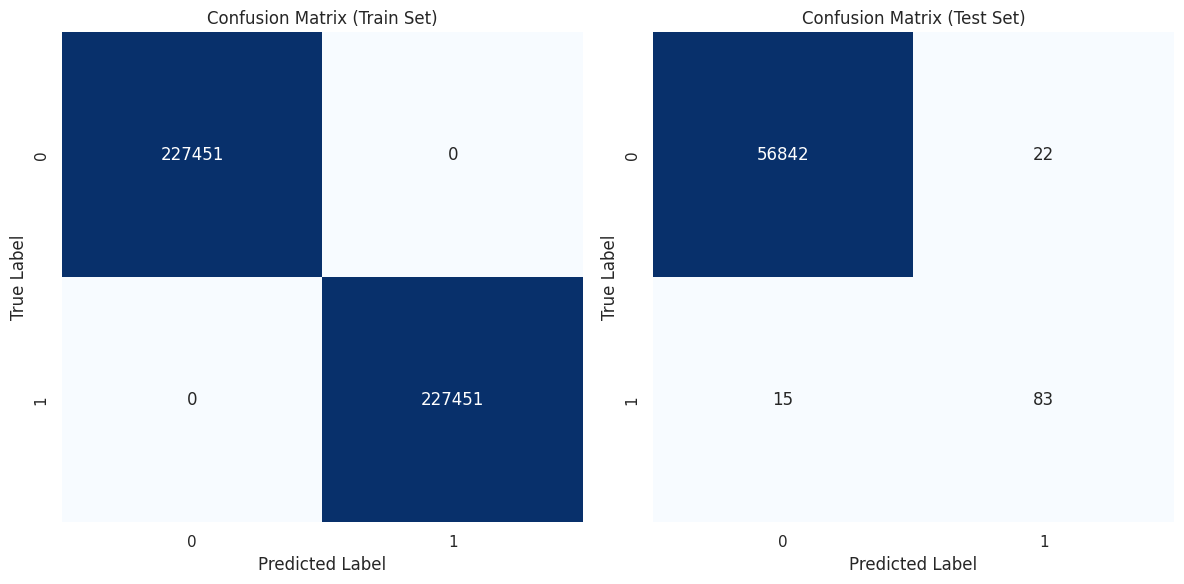


=== BORDERLINE-1 label distribution ===
Class
0    227451
1    227451
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.974037


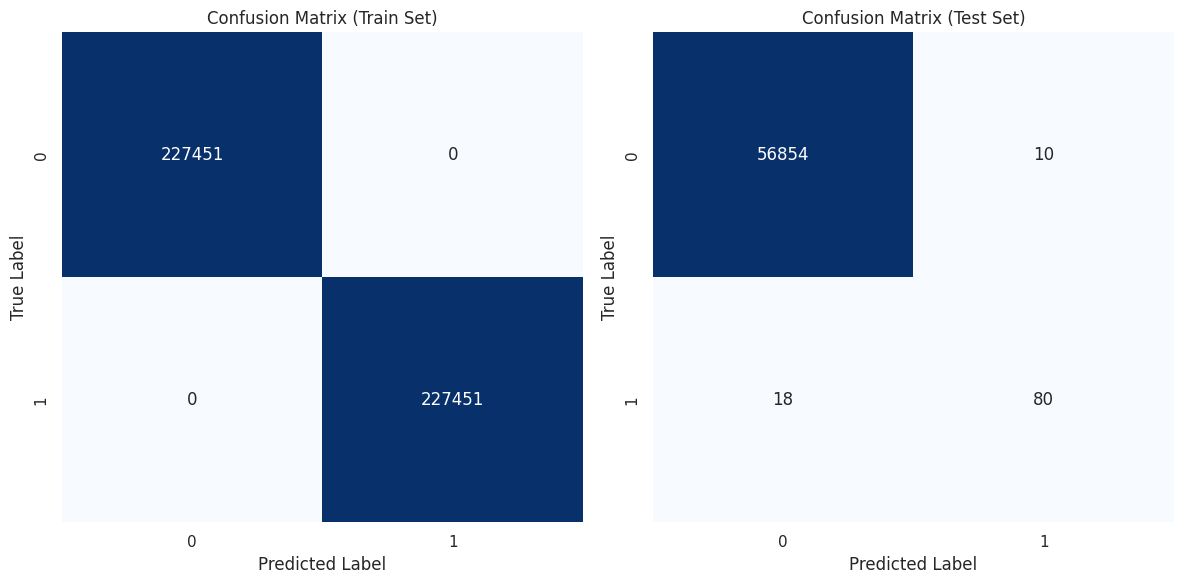


=== BORDERLINE-2 label distribution ===
Class
0    227451
1    227451
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.980036


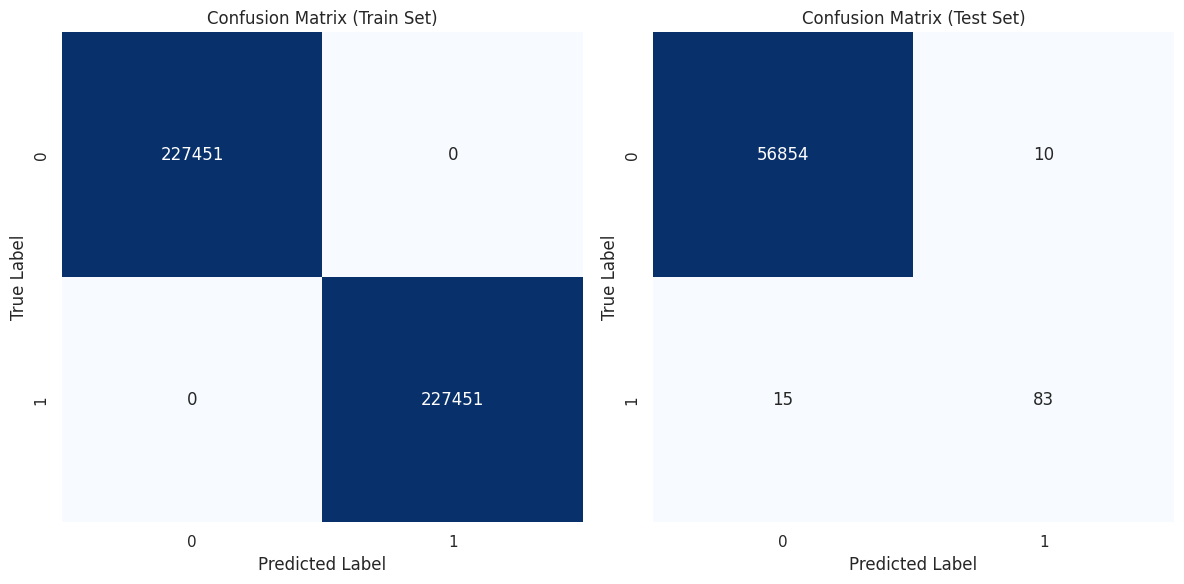


=== SMOTEENN label distribution ===
Class
1    218370
0    209282
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209282
           1       1.00      1.00      1.00    218370

    accuracy                           1.00    427652
   macro avg       1.00      1.00      1.00    427652
weighted avg       1.00      1.00      1.00    427652

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.987259


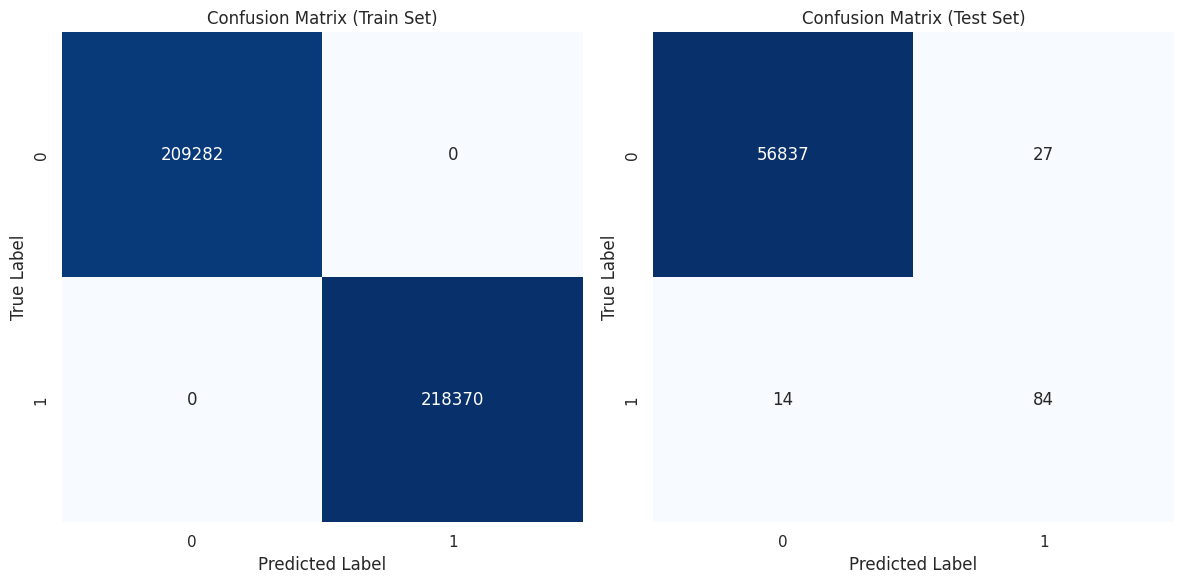


=== SMOTETOMEK label distribution ===
Class
0    226818
1    226818
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226818
           1       1.00      1.00      1.00    226818

    accuracy                           1.00    453636
   macro avg       1.00      1.00      1.00    453636
weighted avg       1.00      1.00      1.00    453636

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.980107


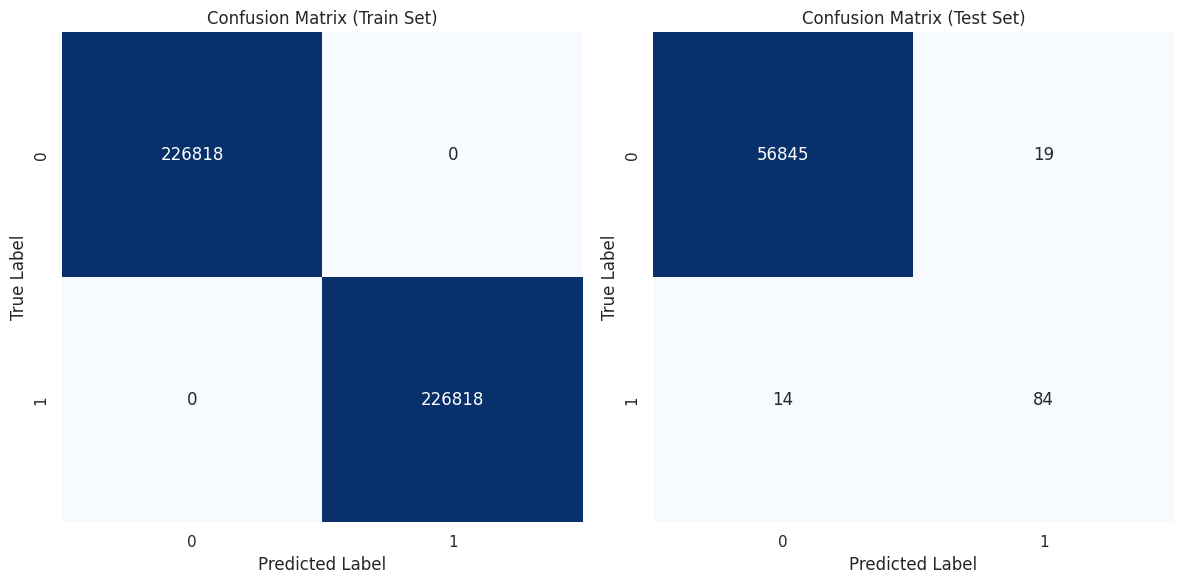

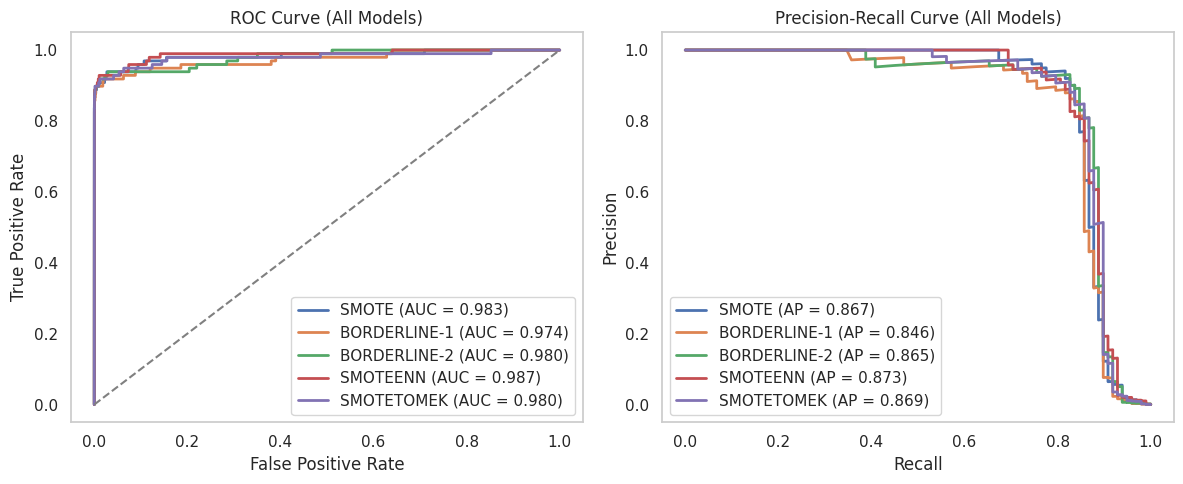

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

all_models = {}

def run_smote_pipeline(smote_method, X_train, y_train, X_test, y_test, model_dict, random_state=42):
    # 建立重抽樣器
    if smote_method == 'smote':
        sampler = SMOTE(random_state=random_state)
    elif smote_method == 'borderline-1':
        sampler = BorderlineSMOTE(kind='borderline-1', random_state=random_state)
    elif smote_method == 'borderline-2':
        sampler = BorderlineSMOTE(kind='borderline-2', random_state=random_state)
    elif smote_method == 'smoteenn':
        sampler = SMOTEENN(random_state=random_state)
    elif smote_method == 'smotetomek':
        sampler = SMOTETomek(random_state=random_state)
    else:
        raise ValueError("Invalid SMOTE method. Choose from: 'smote', 'borderline-1', 'borderline-2', 'smoteenn', 'smotetomek'")

    # 執行重抽樣
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"\n=== {smote_method.upper()} label distribution ===")
    print(pd.Series(y_resampled).value_counts())

    # 建立並訓練模型
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_resampled, y_resampled)

    # 評估模型表現
    evaluate_model(model, X_resampled, y_resampled, X_test, y_test)

    # 可選：畫學習曲線
    # plot_learning_curve(model, X_resampled, y_resampled)

    # 儲存模型以供畫圖
    model_dict[smote_method.upper()] = model

# 要跑的所有方法
methods = ['smote', 'borderline-1', 'borderline-2', 'smoteenn', 'smotetomek']

# 跑整個流程
for method in methods:
    run_smote_pipeline(method, X_train, y_train, X_test, y_test, all_models)
plot_combined_roc_pr_curves(all_models, X_test, y_test)

Class
1    218370
0    209282
Name: count, dtype: int64
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209282
           1       1.00      1.00      1.00    218370

    accuracy                           1.00    427652
   macro avg       1.00      1.00      1.00    427652
weighted avg       1.00      1.00      1.00    427652

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Train AUC: 1.000000
Test AUC: 0.987259


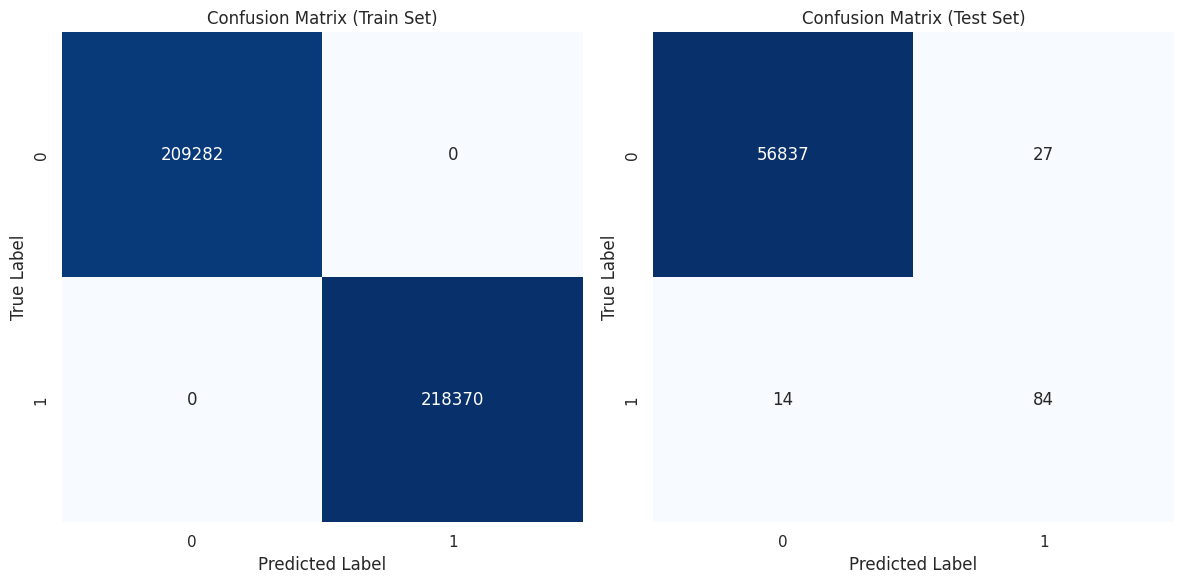

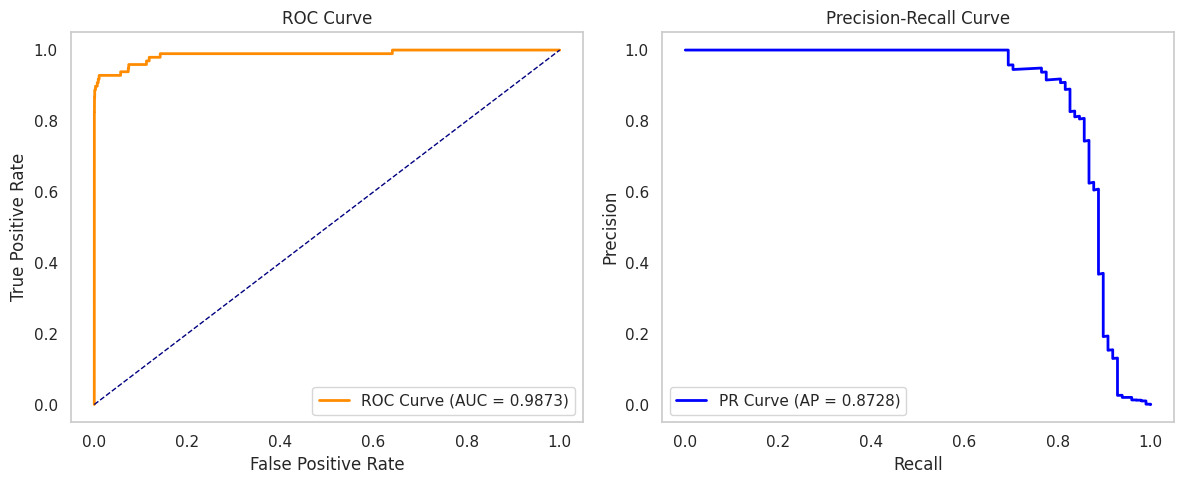

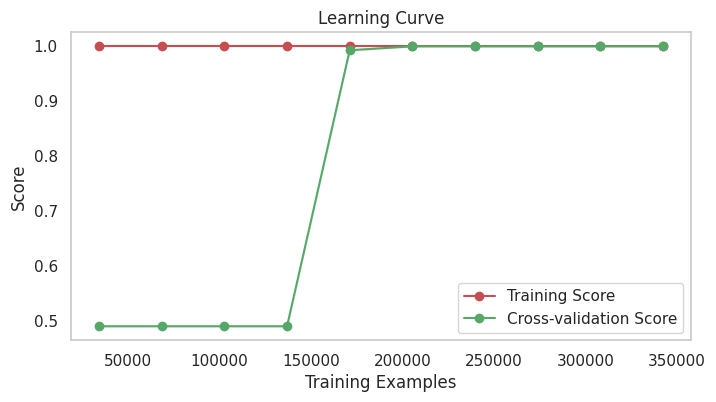

Train Sizes: [ 34212  68424 102636 136848 171060 205272 239484 273696 307908 342121]
Train Scores Mean: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores Mean: [0.48937454 0.48937454 0.48937454 0.48937454 0.99274644 0.99982229
 0.99985736 0.99986438 0.99987139 0.99986204]


In [ ]:
from imblearn.combine import SMOTEENN

# 建立 SMOTEENN 過採樣模型
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# 顯示重新抽樣後的類別分布
print(pd.Series(y_train_resampled).value_counts())

# 建立並訓練 XGBoost 模型
xgb_model_smoteenn = xgb.XGBClassifier(random_state=42,)
xgb_model_smoteenn.fit(X_train_resampled, y_train_resampled)

# 評估模型
evaluate_model(xgb_model_smoteenn, X_train_resampled, y_train_resampled, X_test, y_test)
plot_roc_pr_curves(xgb_model_smoteenn, X_test, y_test)
plot_learning_curve(xgb_model_smoteenn, X_train_resampled, y_train_resampled)

In [ ]:
# 設定 KFold 的參數
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 儲存每次交叉驗證的結果
fold_accuracies = []
fold_aucs = []
fold_reports = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # SMOTEENN 過採樣
    smote_enn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_fold, y_train_fold)

    # 建立 XGBoost 模型
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train_resampled, y_train_resampled)

    # 預測與評估
    y_val_pred = xgb_model.predict(X_val_fold)
    y_val_pred_proba = xgb_model.predict_proba(X_val_fold)

    acc = accuracy_score(y_val_fold, y_val_pred)

    # 二分類 AUC
    if len(np.unique(y_val_fold)) == 2:
        auc = roc_auc_score(y_val_fold, y_val_pred_proba[:, 1])
    else:
        auc = np.nan

    report = classification_report(y_val_fold, y_val_pred, output_dict=True)

    fold_accuracies.append(acc)
    fold_aucs.append(auc)
    fold_reports.append(report)

    print(classification_report(y_val_fold, y_val_pred))
    print(f"AUC: {auc:.4f}")
    print("=" * 50)

# 顯示整體結果
print(f"\n平均準確率 (Accuracy): {np.mean(fold_accuracies):.4f}")
print(f"平均 AUC: {np.nanmean(fold_aucs):.4f}")

Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.83      0.81        99

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9692
Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.85      0.87        99

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9690
Fold 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.85      0.83        98

    accuracy                           1.00     56961
   macro avg       0.91      0.92      0.91     56961
weighted avg       1.00      

# SHAP

In [ ]:
# 建立 SHAP Explainer（針對樹模型使用 TreeExplainer）
explainer = shap.TreeExplainer(xgb_model_smoteenn)
# 計算 SHAP 值
shap_values = explainer(X_train_resampled)

print("X_train_resampled shape:", X_train_resampled.shape)
print("SHAP values shape:", shap_values.shape) # (x, y, z)，x: 樣本數, y: 特徵數量, z: Label的數量

X_train_resampled shape: (429712, 30)
SHAP values shape: (429712, 30)


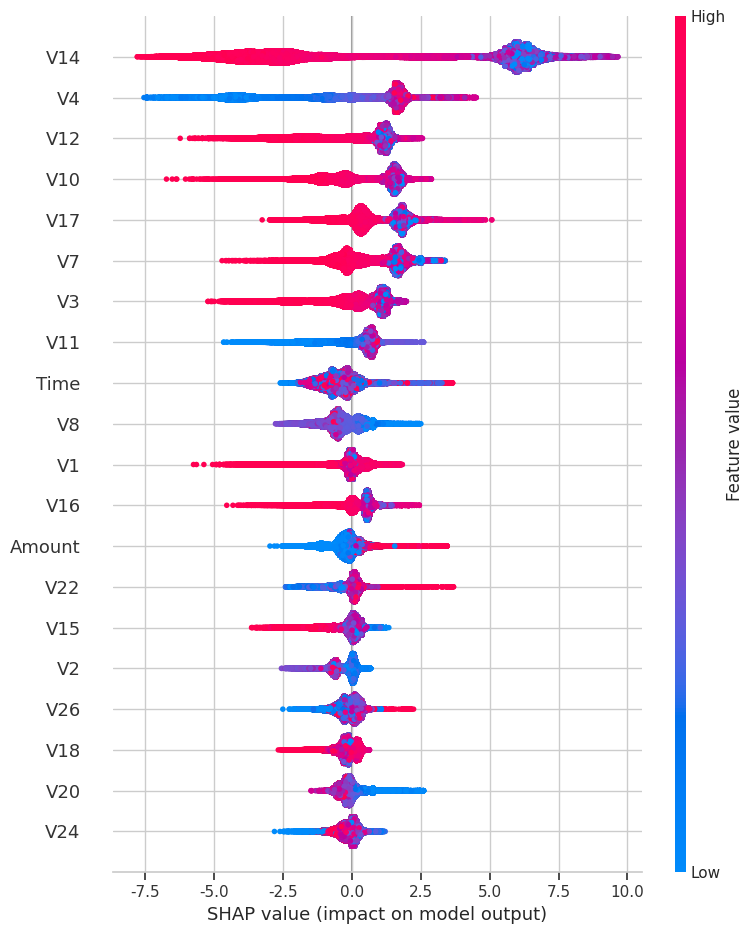

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values.values, X_train_resampled)

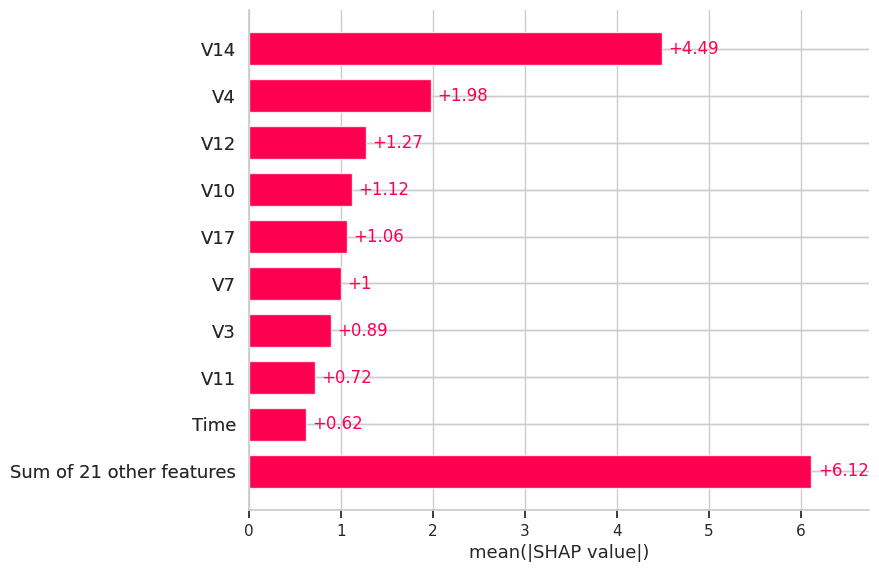

In [ ]:
# Global bar plot
shap.plots.bar(shap_values)

In [ ]:
# 計算每個特徵的平均絕對 SHAP 值
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# 排序並取出前 N 個重要特徵（例如前 top_n 個）
top_n = 10
top_indices = np.argsort(mean_abs_shap)[-top_n:][::-1]
top_features = X_train_resampled.columns[top_indices]

# 印出結果
print(f"Top {top_n} important features:")
print(top_features.tolist())

Top 10 important features:
['V14', 'V4', 'V12', 'V10', 'V17', 'V7', 'V3', 'V11', 'Time', 'V8']


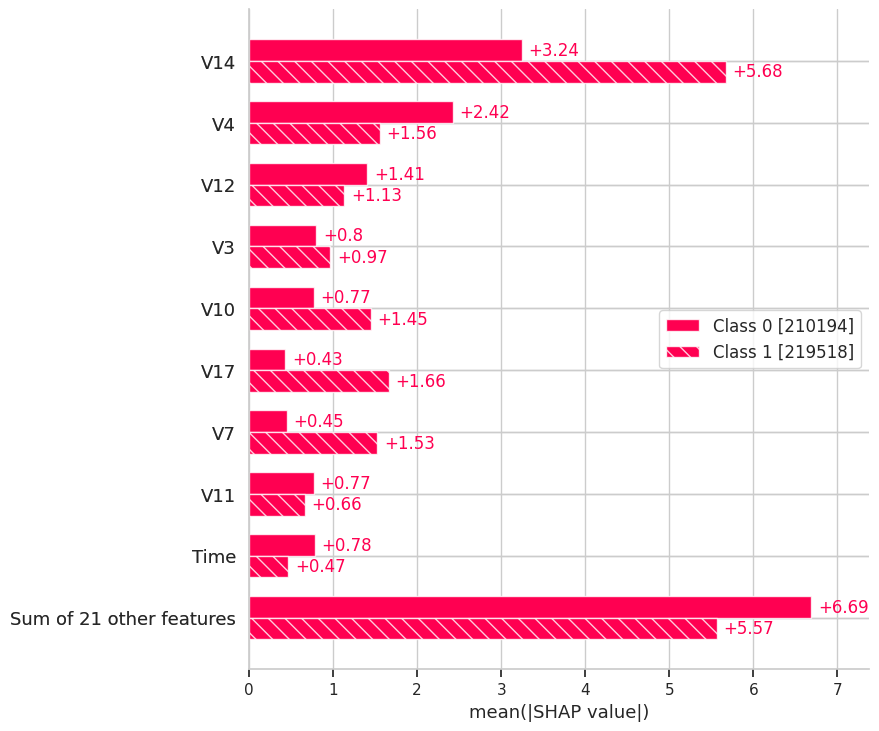

In [ ]:
# Cohort bar plot
# 使用 SMOTE 後的 y_resampled 對應的分類標籤
cohorts = ["Class 0" if y_train_resampled.iloc[i] == 0 else "Class 1" for i in range(len(y_train_resampled))]

shap_cohorts = shap_values.cohorts(cohorts)
shap.plots.bar(shap_cohorts.abs.mean(0))

# 參考連結：

https://www.cnblogs.com/massquantity/p/8592091.html

https://www.cnblogs.com/massquantity/p/9382710.html

